In [ ]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/train'
test_dir = '/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/test'

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/train/covid')))
print(len(os.listdir('/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/train/normal')))
print(len(os.listdir('/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/test/covid')))
print(len(os.listdir('/content/drive/MyDrive/COVID-19 Chest X-ray Image Dataset/test/normal')))

200
200
100
100


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (covid vs. normal)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(
    include_top = False, #because i have my own image of a diff dimension
    input_shape = (256,256,3),
    pooling = 'max', classes = 2,
    weights = 'imagenet'
    )

for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 are not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [ ]:
history = resnet_model.fit(train_data, epochs=11, validation_data=validation_data)

Epoch 1/11
10/10 [==============================] - 138s 14s/step - loss: 0.6029 - accuracy: 0.6656 - val_loss: 0.3858 - val_accuracy: 0.8000
Epoch 2/11
10/10 [==============================] - 138s 14s/step - loss: 0.5933 - accuracy: 0.6812 - val_loss: 0.4460 - val_accuracy: 0.6375
Epoch 3/11
10/10 [==============================] - 134s 14s/step - loss: 0.5561 - accuracy: 0.6781 - val_loss: 0.2194 - val_accuracy: 0.9875
Epoch 4/11
10/10 [==============================] - 137s 14s/step - loss: 0.4215 - accuracy: 0.8281 - val_loss: 0.2200 - val_accuracy: 1.0000
Epoch 5/11
10/10 [==============================] - 133s 14s/step - loss: 0.4689 - accuracy: 0.7937 - val_loss: 0.2101 - val_accuracy: 0.9500
Epoch 6/11
10/10 [==============================] - 138s 14s/step - loss: 0.4897 - accuracy: 0.7469 - val_loss: 0.2388 - val_accuracy: 1.0000
Epoch 7/11
10/10 [==============================] - 119s 12s/step - loss: 0.4681 - accuracy: 0.7844 - val_loss: 0.1712 - val_accuracy: 0.9625
Epoch 

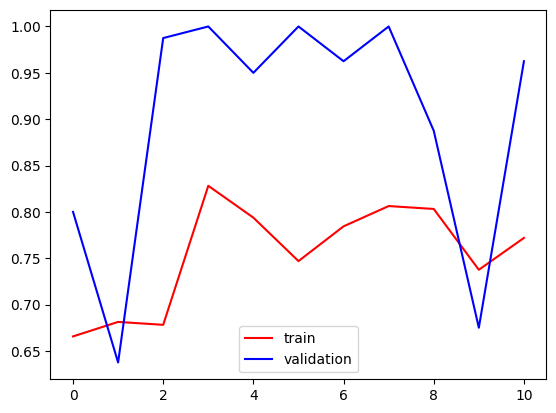

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

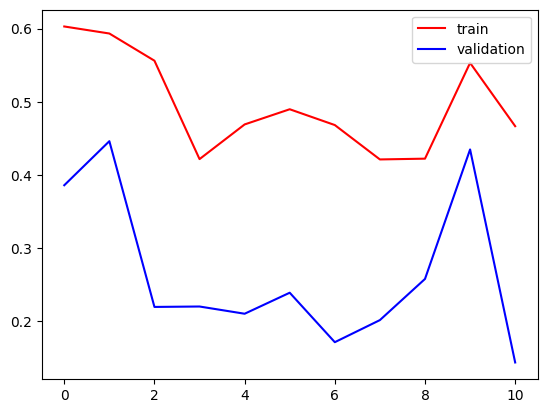

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
resnet_model.evaluate(train_data)

10/10 [==============================] - 105s 10s/step - loss: 0.4020 - accuracy: 0.8438


[0.4019721448421478, 0.84375]

In [ ]:
resnet_model.evaluate(validation_data)

3/3 [==============================] - 25s 7s/step - loss: 0.1434 - accuracy: 0.9625


[0.14343208074569702, 0.9624999761581421]

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 200 images belonging to 2 classes.


In [ ]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

7/7 [==============================] - 63s 8s/step
[[0.95899683]
 [0.1342542 ]
 [0.05428929]
 [0.9597929 ]
 [0.09329594]
 [0.66283756]
 [0.911706  ]
 [0.13914198]
 [0.03832588]
 [0.1388038 ]
 [0.6537509 ]
 [0.8944551 ]
 [0.08738938]
 [0.86969215]
 [0.59678674]
 [0.8321666 ]
 [0.9001165 ]
 [0.11879308]
 [0.7602314 ]
 [0.9448842 ]
 [0.11209132]
 [0.07309056]
 [0.94801074]
 [0.9859594 ]
 [0.99487   ]
 [0.92601997]
 [0.04530326]
 [0.04627735]
 [0.05020808]
 [0.81799495]
 [0.05155603]
 [0.9338604 ]
 [0.6226376 ]
 [0.9732216 ]
 [0.09627446]
 [0.14807557]
 [0.04824459]
 [0.8901728 ]
 [0.8518201 ]
 [0.972936  ]
 [0.03850756]
 [0.92320186]
 [0.05252918]
 [0.02839047]
 [0.04638771]
 [0.55051047]
 [0.91413254]
 [0.14193584]
 [0.12293275]
 [0.2951582 ]
 [0.05231162]
 [0.8192306 ]
 [0.25071365]
 [0.0572737 ]
 [0.09269449]
 [0.9926966 ]
 [0.16467193]
 [0.06553392]
 [0.05097244]
 [0.9921123 ]
 [0.20498236]
 [0.08359551]
 [0.21442582]
 [0.09142909]
 [0.31233191]
 [0.9981824 ]
 [0.09298268]
 [0.9613498

In [ ]:
len(predictions)

200

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 200 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

#Define class labels
class_labels = ['Covid', 'Normal']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[52 48]
 [50 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       100
           1       0.51      0.50      0.51       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



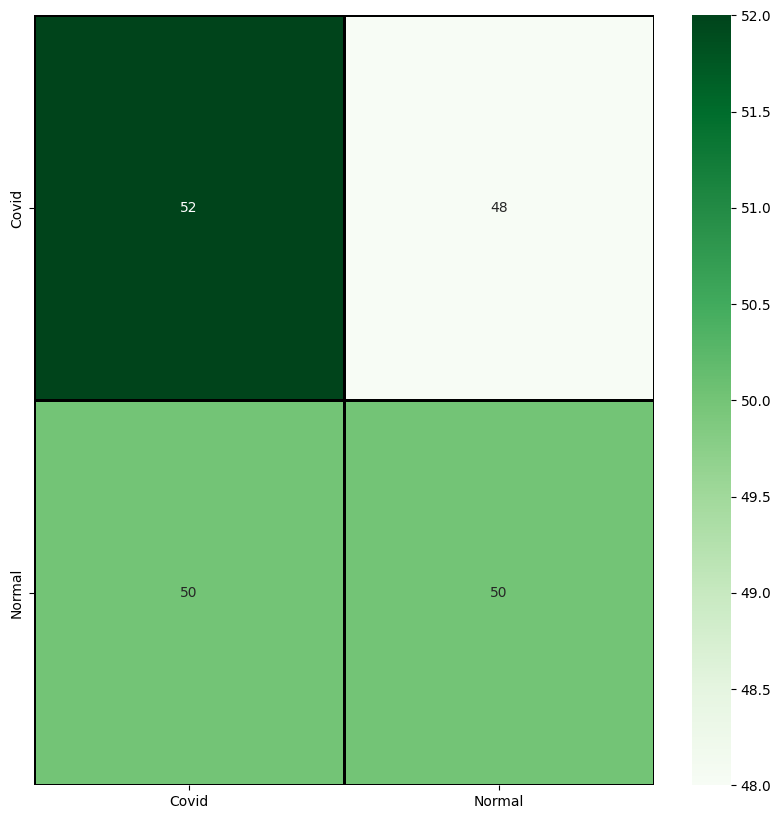

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap='Greens', linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=class_labels, yticklabels=class_labels)
plt.show()